In [133]:
# Makes it easier to debug
%load_ext autoreload
#%load_ext line_profiler
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
import pylab as plt
import numpy as np
import skimage.transform
import skimage.restoration
from tqdm import tqdm
import skimage.filters
import torch
import torch.nn as nn
import typing as tp
from pyrofit.utils import pad_dims
from torch.nn.functional import grid_sample
from pyro import distributions as dist
from pyrofit.lensing.utils import get_meshgrid
from pyrofit.lensing.lenses import SPLELens
from pyrofit.lensing.sources import SersicSource, AnalyticSource
from pyrofit.utils.torchutils import _mid_many, unravel_index
from pyrofit.utils import kNN
from fft_conv_pytorch import fft_conv, FFTConv2d
import swyft
from dataclasses import dataclass
from swyft.alpha.components import (
    RatioEstimatorGaussian1d, MeanStd, SimpleDataset, subsample_posterior,
    get_1d_rect_bounds, append_randomized, valmap, SwyftModel, persist_to_file, 
    equalize_tensors, SwyftTrainer, SampleStore, dictstoremap, DictDataset, SwyftModule, SwyftDataModule, RatioSamples,
    RatioSampleStore
)
import pytorch_lightning as pl
from torch.nn import functional as F

## Problem-specific analysis components

In [135]:
class Model(SwyftModel):
    def fast(self, S):
        d = S['mu'] + torch.randn_like(S['mu'])*0.2
        return dict(data = d)
        
    def slow(self, S):
        a, b, c = S['z']
        x = np.linspace(-1, 1, 100)
        mu = a+b*x + c*x**2
        return dict(mu=mu.float())

    def prior(self, N, bounds = None):
        low = -np.ones(3)
        high = np.ones(3)
        if bounds is not None:
            low, high = bounds['z'].low, bounds['z'].high
        draw = np.array([np.random.uniform(low=low, high=high) for _ in range(N)])
        return SampleStore(z = torch.tensor(draw).float())

## Definition of target image

In [136]:
class InferenceNet(SwyftModule):
    def __init__(self):
        super().__init__()
        #self.online_z_score = swyft.networks.OnlineDictStandardizingLayer(dict(img = (50, 50)))
        self.CNN = torch.nn.Sequential(
            torch.nn.Conv1d(1, 10, 3),
            torch.nn.MaxPool1d(2),
            torch.nn.Conv1d(10, 20, 3),
            torch.nn.MaxPool1d(2),
            torch.nn.Flatten(),
            torch.nn.LazyLinear(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 16),
        )
        self.ptrans = swyft.networks.ParameterTransform(
            6, [(0,), (1,), (2,)], online_z_score=False
        )
        n_marginals, n_block_parameters = self.ptrans.marginal_block_shape
        n_observation_features = 16
        self.classifier = swyft.networks.MarginalClassifier(
            n_marginals,
            n_observation_features + n_block_parameters,
            hidden_features=256,
            dropout_probability = 0.1,
            num_blocks=3,
        )
        
    def forward(self, x, z):
        # Digesting x
        data = x['data']
        #x = self.online_z_score(x)['img']
        x = self.CNN(data.unsqueeze(1)).squeeze(1)
        
        # Digesting z
        z = self.ptrans(z['z'])
        
        # Combine!
        x, z = equalize_tensors(x, z)
        ratios = self.classifier(x, z)
        w = RatioSamples(z.squeeze(-1), ratios)
        return dict(z=w)

## Workflow



100%|██████████| 1/1 [00:00<00:00, 1708.47it/s]


100%|██████████| 1/1 [00:00<00:00, 4253.86it/s]


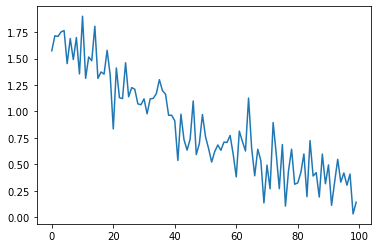

In [138]:
m = Model()
s0 = m.sample(1)[0]
plt.plot(s0['data'])

In [ ]:
b = None
m = Model()
for i in range(3):
    r = InferenceNet()
    s = m.simulate(5000, bounds = b)
    d = SwyftDataModule(s, model = m, batch_size = 256)
    t = SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = 5)
    t.fit(r, d)
    p = t.infer(r, d, condition_x = s0)   # Weighted posterior samples
    b = get_1d_rect_bounds(p)

/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/torch-1.9.0-py3.8-linux-x86_64.egg/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/5000 [00:00<?, ?it/s]

 14%|█▍        | 712/5000 [00:00<00:00, 7118.87it/s]

 28%|██▊       | 1424/5000 [00:00<00:00, 6687.83it/s]

 42%|████▏     | 2121/5000 [00:00<00:00, 6810.52it/s]

 56%|█████▋    | 2814/5000 [00:00<00:00, 6853.08it/s]

 70%|███████   | 3501/5000 [00:00<00:00, 6675.76it/s]

 84%|████████▍ | 4203/5000 [00:00<00:00, 6786.52it/s]

100%|██████████| 5000/5000 [00:00<00:00, 6795.34it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
------------------------------------------

Validation sanity check: 0it [00:00, ?it/s]

/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/torch-1.9.0-py3.8-linux-x86_64.egg/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 20it [00:00, ?it/s]



  0%|          | 0/5000 [00:00<?, ?it/s]

 13%|█▎        | 666/5000 [00:00<00:00, 6655.50it/s]

 28%|██▊       | 1383/5000 [00:00<00:00, 6953.15it/s]

 42%|████▏     | 2090/5000 [00:00<00:00, 7005.97it/s]

 56%|█████▌    | 2791/5000 [00:00<00:00, 6999.25it/s]

 70%|██████▉   | 3491/5000 [00:00<00:00, 6998.46it/s]

 84%|████████▍ | 4191/5000 [00:00<00:00, 6954.79it/s]

100%|██████████| 5000/5000 [00:00<00:00, 6920.22it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | CNN        | Sequential         | 2.7 K 
1 | ptrans     | ParameterTransform | 0     
2 | classifier | MarginalClassifier | 1.2 M 
--------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.843     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 5it [00:00, ?it/s]



  0%|          | 0/5000 [00:00<?, ?it/s]

 13%|█▎        | 663/5000 [00:00<00:00, 6629.06it/s]

 28%|██▊       | 1375/5000 [00:00<00:00, 6912.83it/s]

 41%|████▏     | 2070/5000 [00:00<00:00, 6925.61it/s]

 55%|█████▌    | 2768/5000 [00:00<00:00, 6945.22it/s]

 69%|██████▉   | 3463/5000 [00:00<00:00, 6921.43it/s]

 83%|████████▎ | 4157/5000 [00:00<00:00, 6926.05it/s]

100%|██████████| 5000/5000 [00:00<00:00, 6879.99it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | CNN        | Sequential         | 2.7 K 
1 | ptrans     | ParameterTransform | 0     
2 | classifier | MarginalClassifier | 1.2 M 
--------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.843     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [111]:
z = p['z'].sample(10000, replacement = True)
len(z)

10000

(-1.0, 1.0)

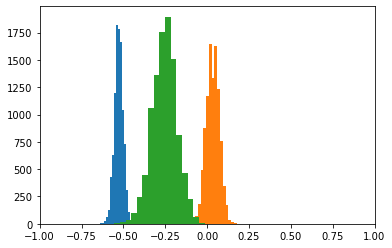

In [112]:
plt.hist(z[:,0].numpy(), bins = 20);
plt.hist(z[:,1].numpy(), bins = 20);
plt.hist(z[:,2].numpy(), bins = 20);
plt.xlim(-1, 1)